In [1]:
import torch
import numpy as np
from fairseq import utils,tasks
from fairseq import checkpoint_utils
from utils.eval_utils import eval_step
from tasks.mm_tasks.caption import CaptionTask
from models.ofa import OFAModel
from PIL import Image
import pandas as pd
import os, random
from tqdm import tqdm

# Register caption task
tasks.register_task('caption',CaptionTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False

In [3]:
# Load pretrained ckpt & config
overrides={"bpe_dir":"utils/BPE", "eval_cider":False, "beam":5, "max_len_b":16, "no_repeat_ngram_size":3, "seed":7}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths('checkpoints/caption.pt'),
        arg_overrides=overrides
    )

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

2022-05-22 17:25:52 | INFO | tasks.ofa_task | source dictionary: 59457 types
2022-05-22 17:25:52 | INFO | tasks.ofa_task | target dictionary: 59457 types
/home/sergey/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()
def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for caption task
def construct_sample(image: Image):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(" what does the image describe?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask
        }
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/home/sergey/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [5]:
all_path_images = ! for f in ../../communities/*/images/*; do echo "$f"; done

In [6]:
path_to_pkl = ! ls ../OCR_Speller/dataset_social_with_ocr_spell_sent_2.pkl

In [7]:
unpickled_df = pd.read_pickle(*path_to_pkl) 

In [8]:
unpickled_df.head()

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,size_text_ocr,spell_text_ocr_image,sentiment_text_post_1,sentiment_text_post_2,level_sentiment_post_1,level_sentiment_post_2,sentiment_text_ocr_image_1,sentiment_text_ocr_image_2,level_sentiment_ocr_1,level_sentiment_ocr_2
0,-91050183,25773616,5/20/2022 22:01,4748,231435.0,115,68,,https://sun1-23.userapi.com/s/v1/ig2/83irVBt8D...,https://vk.com/wall-91050183_25773616,...,12,раньше я путал билана и лазарева теперь путаю ...,,,NaN,NaN,skip,negative,0.370235,0.348655
1,-91050183,25772897,5/20/2022 20:16,5140,392142.0,244,125,"Девушки были ярче и красивее, когда не было со...",https://sun1-30.userapi.com/s/v1/ig2/vZBz-4-pE...,https://vk.com/wall-91050183_25772897,...,0,,skip,positive,0.191943,0.173298,,,NaN,NaN
2,-91050183,25772387,5/20/2022 18:46,8414,466541.0,246,434,,https://sun1-55.userapi.com/s/v1/ig2/4ZynfzBVL...,https://vk.com/wall-91050183_25772387,...,22,"гордон рассказал, что не считает проблемой то ...",,,NaN,NaN,neutral,skip,0.592677,0.262852
3,-91050183,25771877,5/20/2022 17:16,4889,315293.0,113,209,Рианна показала своего сына �,https://sun1-83.userapi.com/s/v1/ig2/rlQeqTl8A...,https://vk.com/wall-91050183_25771877,...,0,,positive,neutral,0.355785,0.281416,,,NaN,NaN
4,-91050183,25770890,5/20/2022 14:16,10287,485783.0,177,236,Жожо просто великолепен �,https://sun1-91.userapi.com/s/v1/ig2/8YP8Tz3gK...,https://vk.com/wall-91050183_25770890,...,0,,positive,negative,0.970698,0.177821,,,NaN,NaN


In [51]:
unpickled_df.head()

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,size_text_ocr,spell_text_ocr_image,sentiment_text_post_1,sentiment_text_post_2,level_sentiment_post_1,level_sentiment_post_2,sentiment_text_ocr_image_1,sentiment_text_ocr_image_2,level_sentiment_ocr_1,level_sentiment_ocr_2
0,-95355317,2106072,2022-05-12 16:03:00,27,2956.0,0,29,"""Двач""",https://sun1-23.userapi.com/s/v1/ig2/MdXWO9Vs1...,https://vk.com/wall-95355317_2106072,...,22,у ку кв слушало вы здравствуй в когда мама гов...,neutral,skip,1.00001,0.106701,neutral,negative,0.399822,0.239359
1,-95355317,2106041,2022-05-12 12:03:02,6,6342.0,4,9,"""Двач""",https://sun1-18.userapi.com/s/v1/ig2/gwRD8wNJH...,https://vk.com/wall-95355317_2106041,...,15,когда вс жизнь мечтала стать парнем: 2018 2018...,neutral,skip,1.00001,0.106701,neutral,positive,0.986787,0.016925
2,-95355317,2106036,2022-05-12 11:03:00,42,5472.0,7,8,"""Двач""",https://sun1-57.userapi.com/s/v1/ig2/8uYDHCNDZ...,https://vk.com/wall-95355317_2106036,...,30,4 8900 89387 7д пуча вы не можете со мной так ...,neutral,skip,1.00001,0.106701,neutral,skip,0.901931,0.065615
3,-95355317,2106029,2022-05-12 10:03:00,9,8934.0,7,5,"""Двач""",https://sun1-55.userapi.com/s/v1/ig2/iyfPNRSKA...,https://vk.com/wall-95355317_2106029,...,6,не могу понять стоит или лежит,neutral,skip,1.00001,0.106701,neutral,negative,0.976321,0.275140
4,-95355317,2105985,2022-05-11 20:10:00,50,5973.0,2,33,"""Двач""",https://sun1-21.userapi.com/s/v1/ig2/gtlbA9oBj...,https://vk.com/wall-95355317_2105985,...,7,"боже, спаси сохрани как сохранять? вредили рч?",neutral,skip,1.00001,0.106701,neutral,skip,0.538993,0.245095


In [ ]:
unpickled_df['type_post']

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
unpickled_df['description_image'] = ''

In [12]:
cnt = 0
for img_path in tqdm(all_path_images):
    cnt += 1
    owner_id = img_path.split(os.sep)[-1].split('_')[1]
    id_post = img_path.split(os.sep)[-1].split('_')[-1].split('.')[0]
#     print(owner_id, id_post)
    if unpickled_df.loc[(unpickled_df['id_community'].astype(str) == owner_id) & (unpickled_df['id_post'] == int(id_post))]['type_post'].values[0] == 'text':
        continue
    if unpickled_df.loc[(unpickled_df['id_community'].astype(str) == owner_id) & (unpickled_df['id_post'] == int(id_post))]['description_image'].values[0] != '':
        continue
    try:
#             img_path = base_dir + '/' + my_image
#         img = image.load_img(img_path, target_size=(224, 224))
        image = Image.open(img_path)
    
        sample = construct_sample(image)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
        # Show picture
#         plt.imshow(img)
#         plt.show()
        with torch.no_grad():
            result, scores = eval_step(task, generator, models, sample)
#         display(image)
#         print('Caption: {}'.format(result[0]['caption']))
#         print(result[0]['caption'])
        unpickled_df.loc[(unpickled_df['id_community'].astype(str) == owner_id) & (unpickled_df['id_post'] == int(id_post)), 'description_image'] = result[0]['caption'] 
    except FileNotFoundError:
        print('Entered image name does not exist.', img_path)
    except:
        print(result[0]['caption'])
        continue

    if cnt % 5000 == 0:
        unpickled_df.to_csv('dataset_with_ocr_spell_sent_ofa_2.tsv', sep='\t')

unpickled_df.to_csv('dataset_with_ocr_spell_sent_ofa_2.tsv', sep='\t')
unpickled_df.to_pickle("./dataset_social_with_ocr_spell_sent_ofa_2.pkl")  

 55%|█████▍    | 61749/113176 [8:13:37<3:38:04,  3.93it/s] 

an old cartoon with a dog and a cat sitting in a chair talking to a


 76%|███████▋  | 86419/113176 [11:31:20<4:08:14,  1.80it/s] 

may the force be with you yoda meme


100%|██████████| 113176/113176 [14:56:54<00:00,  2.10it/s]  


In [57]:
unpickled_df.loc[(unpickled_df['type_post'] == 'img_text') & (unpickled_df['description_image'] != '')]

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,spell_text_ocr_image,sentiment_text_post_1,sentiment_text_post_2,level_sentiment_post_1,level_sentiment_post_2,sentiment_text_ocr_image_1,sentiment_text_ocr_image_2,level_sentiment_ocr_1,level_sentiment_ocr_2,description_image
16869,-95355317,1912442,2018-11-05 22:30:00,87,7798.0,1,1,⋅Двach⋅,https://sun1-20.userapi.com/s/v1/if2/kLWc0Mq67...,https://vk.com/wall-95355317_1912442,...,5 жутких нападений акул 11 млн просмотра з 3 т...,neutral,skip,0.99428,0.044691,neutral,skip,0.901931,0.129413,a screenshot of a person laying on the beach w...
16870,-95355317,1912428,2018-11-05 21:30:00,391,15251.0,13,3,⋅Двach⋅,https://sun1-21.userapi.com/s/v1/if2/YM2tKHCUk...,https://vk.com/wall-95355317_1912428,...,::2 = | :2 успокойся успокойся окещелро челу д...,neutral,skip,0.99428,0.044691,neutral,skip,0.554480,0.122533,a picture of three people with their arms arou...
16871,-95355317,1912419,2018-11-05 20:30:00,163,7869.0,3,0,⋅Двach⋅,https://sun1-28.userapi.com/s/v1/if2/ZA7HDKiei...,https://vk.com/wall-95355317_1912419,...,когда стоишь в автобусе и он начинает резко по...,neutral,skip,0.99428,0.044691,neutral,skip,0.912446,0.112805,a man sitting on top of a roof
16872,-95355317,1912417,2018-11-05 19:30:00,89,8709.0,0,1,⋅Двach⋅,https://sun1-24.userapi.com/s/v1/if2/_qN8PvTbm...,https://vk.com/wall-95355317_1912417,...,::ю зля соб4к4,neutral,skip,0.99428,0.044691,neutral,skip,0.987189,0.384922,a dog sitting on the ledge of a window
16873,-95355317,1912407,2018-11-05 18:30:00,164,8975.0,9,0,⋅Двach⋅,https://sun1-93.userapi.com/s/v1/if2/8AzGL08qW...,https://vk.com/wall-95355317_1912407,...,я до того как выпили после,neutral,skip,0.99428,0.044691,neutral,negative,0.928419,0.053413,two pictures of a man sitting on a bench and a...
16874,-95355317,1912403,2018-11-05 17:30:00,120,12800.0,3,2,⋅Двach⋅,https://sun1-89.userapi.com/s/v1/if2/Vsclu7tvs...,https://vk.com/wall-95355317_1912403,...,когда кто-то спрашивает почему я не женился не...,neutral,skip,0.99428,0.044691,negative,neutral,0.705795,0.256842,a penguin in a box with a label on it
16875,-95355317,1912396,2018-11-05 16:30:00,129,9231.0,4,2,⋅Двach⋅,https://sun1-25.userapi.com/s/v1/if2/l-uQVs2QQ...,https://vk.com/wall-95355317_1912396,...,ткаденег откошекия нехва работа,neutral,skip,0.99428,0.044691,negative,neutral,0.320831,0.294225,a man is spraying water on a train
16876,-95355317,1912390,2018-11-05 14:55:00,173,11058.0,12,1,⋅Двach⋅,https://sun1-97.userapi.com/s/v1/if2/MIorHv4ob...,https://vk.com/wall-95355317_1912390,...,"в новой ;о5 появился эмодзи, который полностью...",neutral,skip,0.99428,0.044691,neutral,positive,0.948165,0.256842,a smiley face with
16877,-95355317,1912374,2018-11-05 13:30:00,185,12058.0,13,10,⋅Двach⋅,https://sun1-91.userapi.com/s/v1/if2/xVrie04LF...,https://vk.com/wall-95355317_1912374,...,9 кругов ава ] там 2.з4еся зимний 4.колчак 5.е...,neutral,skip,0.99428,0.044691,neutral,skip,0.847978,0.300756,a painting of a hot air balloon with the names...
16878,-95355317,1912368,2018-11-05 12:30:00,132,9615.0,2,3,⋅Двach⋅,https://sun1-96.userapi.com/s/v1/if2/YS2za6OXQ...,https://vk.com/wall-95355317_1912368,...,когда очень стараешься и всё потихоньку станов...,neutral,skip,0.99428,0.044691,positive,negative,0.275140,0.228166,a dog is sitting on a purple blanket


In [31]:
# Download an image from COCO or you can use other images with wget
# ! wget http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg 
# ! mv 3836680545_2ccb331621_z.jpg  test.jpg
image = Image.open('./test18.jpg')

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [32]:
# Run eval step for caption
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)

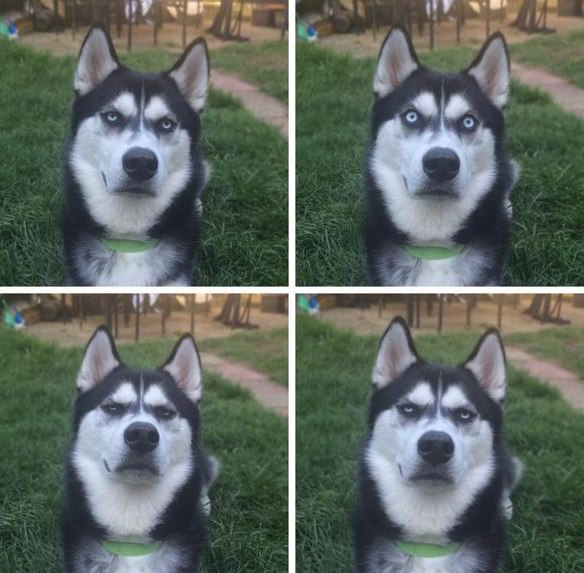

Caption: four pictures of a dog in the grass


In [33]:
display(image)
print('Caption: {}'.format(result[0]['caption']))

In [4]:
image = Image.open('./test_img.png')

# Construct input sample & preprocess for GPU if cuda available
sample = construct_sample(image)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

In [5]:
with torch.no_grad():
    result, scores = eval_step(task, generator, models, sample)

/home/sergey/maga_diploma/models/OFA/models/sequence_generator.py:698: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = bbsz_idx // beam_size


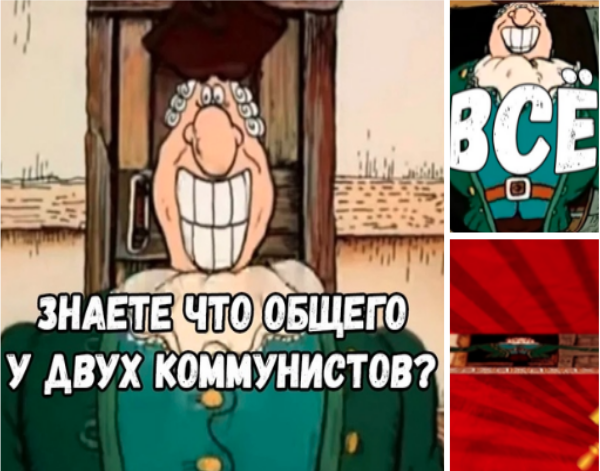

Caption: a screenshot of a cartoon with the text shade to obuelo and a picture


In [6]:
display(image)
print('Caption: {}'.format(result[0]['caption']))